# Advanced KNN  
**Author:** Aman (Documenting my ML learning journey)

"""
In this notebook, I am taking my understanding of **K-Nearest Neighbors (KNN)** to the next level.  
In my previous notebook, I implemented and explained the basics of KNN for classification.  

But knowing how to just "use" KNN is not enough — I want to **really understand** its inner workings,  
its limitations, and when to use it (or avoid it!) in real-world ML projects.

So here, I will:
- Recap KNN briefly
- Explore KNN Regressor (yes, KNN is not just for classification!)
- Dive into its hyperparameters and their effects
- Learn about weighted KNN
- Experiment with different distance metrics
- Discuss scaling, complexity, and speedups (kd-tree, ball-tree)
- Talk about challenges like imbalanced data and curse of dimensionality
- Reflect on what I learned and when I’d actually use KNN in practice
"""


# Quick Recap of what KNN does

In my basic KNN notebook, I learned that KNN is a **lazy learner**:
- It doesn’t build a traditional "model" during training.
- It just stores the training data.
- When a new data point comes, it finds the **k nearest neighbors** and predicts based on majority vote (classification) or average (regression).

This was good to build **intuition**, but now I want to look at more **practical, advanced topics** like regression, distance metrics, scaling, and performance.


# KNN for Regression (KNeighborsRegressor)

Yes, KNN can also be used for **regression** problems where the output is continuous.  
Instead of taking a majority vote, KNN regressor takes the **average of the k nearest neighbors' target values**.

This is super intuitive — if you want to predict the house price in a new area,  
you look at the prices of k most similar houses nearby and take the average.  
That's exactly what KNN regression does.


**Simple KNN Regressor**

In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# synthetic regression data (1 feature so we can visualize easily)
X, y = make_regression(n_samples=100, n_features=1, noise=15, random_state=42)

In [3]:
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# train a KNN Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [6]:
# Predictions
y_pred = knn_reg.predict(X_test)

In [9]:
# evaluate
print(" Mean Squared Error:", mean_squared_error(y_test, y_pred))
print(" R² Score:", r2_score(y_test, y_pred))

 Mean Squared Error: 239.813691338355
 R² Score: 0.8713245407583777


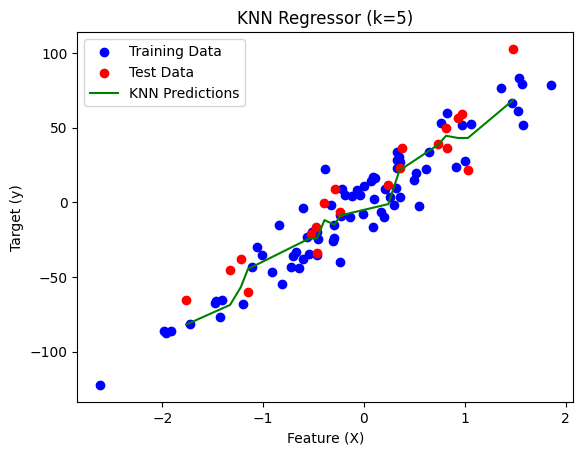

In [10]:
# Visualization
# Sort values for a smooth line
sorted_idx = np.argsort(X_test.flatten())
plt.scatter(X_train, y_train, color="blue", label="Training Data")
plt.scatter(X_test, y_test, color="red", label="Test Data")
plt.plot(X_test[sorted_idx], y_pred[sorted_idx], color="green", label="KNN Predictions")
plt.title("KNN Regressor (k=5)")
plt.xlabel("Feature (X)")
plt.ylabel("Target (y)")
plt.legend()
plt.show()

# My Takeaways

- KNN regressor is **super simple** but surprisingly powerful for small, smooth datasets.
- I can clearly see how the prediction line is "piecewise" — it’s not a perfect curve but adjusts based on local neighbors.
- The choice of k matters a lot:
  - Small k → very wiggly prediction (can overfit).
  - Large k → smoother prediction (can underfit).

I love this experiment because I can **see** the effect visually — this helps me truly "get it."